In [1]:
from dataclasses import asdict

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.models.neurad import NeuRADModel, NeuRADModelConfig
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig


In [2]:

sequence = "001"

pipeline_config = DiffusionNerfConfig(
    max_steps=40001,
    calc_fid_steps=tuple(range(0, 40001, 5000)),
    ray_patch_size=(128, 128),
    nerf_checkpoint=f"models/diffusionnerf/base-neurad/{sequence}/nerfstudio_models/step-000040000.ckpt",
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",), sequence=sequence),
        train_num_rays_per_batch=16384,
        eval_num_rays_per_batch=16384,
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
    )
pipe = pipeline_config.setup(device="cuda")

Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
import torch

# We don't use the model so we can GPU memory by removing it
del pipe.diffusion_model
torch.cuda.empty_cache()

In [4]:
from copy import deepcopy
from typing import Tuple
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfPipeline, rotate_around
from torch import Tensor
import torch

from nerfstudio.cameras.cameras import Cameras


def shift_cameras(pipe: DiffusionNerfPipeline, cameras: Cameras, pose_offset: Tensor) -> Tuple[Cameras, Tensor]:
    cameras = deepcopy(cameras)
    device = cameras.device
    aug_translation = pose_offset[..., :3].to(device=device)  # 3
    aug_rotation = pose_offset[..., 3:].to(device=device)  # 3

    c2w = cameras.camera_to_worlds 
    translation = c2w[..., :3] @ aug_translation

    local_rotation = (  # Chain together rotations, X -> Y -> Z
        rotate_around(aug_rotation[2], 2)
        @ rotate_around(aug_rotation[1], 1)
        @ rotate_around(aug_rotation[0], 0)
    ).to(device)
    c2w[:, :3, :3] = local_rotation @ c2w[:, :3, :3]
    c2w[:, :3, 3:4] += translation.reshape(-1, 3, 1)

    cameras.camera_to_worlds = c2w

    with torch.no_grad():
        img_out = pipe.model.get_outputs_for_camera(cameras)

    return cameras, img_out

In [5]:
from PIL import Image

def prettify_img(img: Tensor, title: str = ""):
    img = img.detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    pil_image = Image.fromarray((img * 255).astype("uint8")) 
    return pil_image

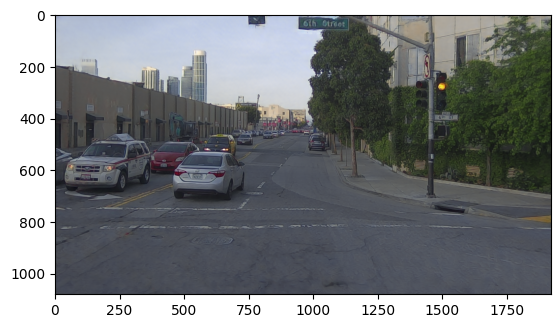

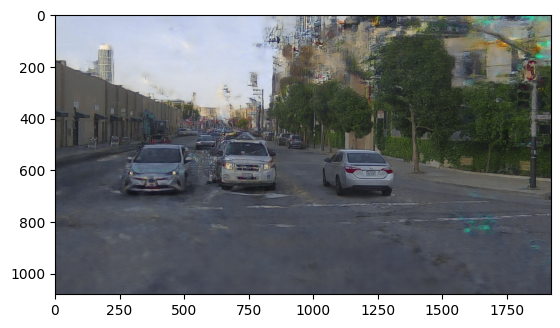

In [18]:
import pickle

from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig

pipe.eval()

camera = pipe.datamanager.eval_dataset.cameras[10:11]

with torch.no_grad():
    outputs = pipe.model.get_outputs_for_camera(camera.to("cuda"))

import matplotlib.pyplot as plt

plt.imshow(outputs["rgb"].detach().cpu())
plt.show()


shifted_camera, neurad_img = shift_cameras(pipe, camera.to("cuda"), PoseConfig(pos_x=-8, rot_z=-10).tensor_rad)
plt.imshow(neurad_img["rgb"].detach().cpu())

In [ ]:
from PIL import Image
import itertools as it
from pathlib import Path
import torch
import tqdm
    

models = [
    None, "un4", "un4cn4", "un128", "un128cn128"
]

diffused_imgs = {}

for diffusion_model_name in models:
    if diffusion_model_name is None:
        lora_weights = None 
        models_to_load_lora = ()
    else:
        lora_weights = f"models/lora/{sequence}/s01/{diffusion_model_name}"
        models_to_load_lora = ("unet", "controlnet") if "cn" in diffusion_model_name else ("unet",)
    torch.cuda.empty_cache()
    diffusion_model = DiffusionModelConfig(
        dtype="fp16",
        lora_weights=lora_weights,
        models_to_load_lora=models_to_load_lora,
        models_to_train_lora=(),
    ).setup(device="cuda")
    
    
    with torch.no_grad():
        diffused_imgs["none" if diffusion_model_name is None else diffusion_model_name] = diffusion_model.get_diffusion_output(neurad_img, rgb_key="rgb")

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiat

In [ ]:
output_idx = 0
prettify_img(neurad_img["rgb"]).save(f"experiments/Images/finetune_improvement/{sequence}/neurad_{output_idx}.png")
for name, render in diffused_imgs.items():
    prettify_img(diffused_imgs[name]["rgb"][0]).save(f"experiments/Images/finetune_improvement/{sequence}/{'base' if name == 'none' else name}_{output_idx}.png")

In [ ]:

torch.cuda.empty_cache()
diffusion_model = DiffusionModelConfig(
    dtype="fp16",
    lora_weights=None,
    models_to_load_lora=(),
    models_to_train_lora=(),
).setup(device="cuda")

seeds = [0, 1, 2]

diffused_imgs_seed = {}
for seed in seeds:
    with torch.no_grad():
        diffused_imgs_seed[seed] = diffusion_model.get_diffusion_output(neurad_img, rgb_key="rgb", seed=seed)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
